<a href="https://colab.research.google.com/github/amanullahshah32/CSE498R/blob/main/SentimentAnlysisWithXAI%2BBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install Required Libraries


In [10]:
!pip install transformers torch torch-optimizer imbalanced-learn scikit-learn matplotlib --quiet


#2. Load and Preprocess The Data

In [11]:
import pandas as pd

from sklearn.model_selection import train_test_split



# Load your scraped data from the provided URL

url = "https://raw.githubusercontent.com/amanullahshah32/Review-Scraping/refs/heads/main/Dataset/cleaned_dataset.csv"

df = pd.read_csv(url)



# Drop rows where 'review_description' or 'rating' are missing

df.dropna(subset=['review_description', 'rating'], inplace=True)

# Sample 20,000 rows randomly
df = df.sample(n=20000, random_state=42)

# Shuffle the sampled dataset

df = df.sample(frac=1, random_state=42).reset_index(drop=True)



# Create a sentiment column based on rating (assuming rating scale is 1-5)

df['sentiment'] = df['rating'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))



# Split the data into training and validation sets

train_texts, val_texts, train_labels, val_labels = train_test_split(df['review_description'], df['sentiment'], test_size=0.2, random_state=42)



# Convert labels to list

train_labels = train_labels.tolist()

val_labels = val_labels.tolist()



# Display the first few rows

df.head()




,source,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,language_code,country_code,app_name,sentiment
0,Google Play,950646a1-c3af-491d-8293-f05be2150a48,A Google user,NaN,Seems to have just about every drug covered wi...,5,1,2019-03-18 16:33:45,NaN,NaN,2.9.1,en,us,com.drugscom.app,2
1,Google Play,f28aa7ef-407e-41a5-bf99-a36a429bc091,A Google user,NaN,"Interesting, informative, and educational.",5,0,2020-07-14 10:58:41,NaN,NaN,7.4.3,en,us,com.lbrc.PeriodCalendar,2
2,Google Play,d829efbd-3415-4a11-b3a4-8a5eee3fd2d0,A Google user,NaN,it's has very useful value,5,0,2017-11-29 02:05:31,NaN,NaN,1.7.1,en,us,com.twgbd.dims,2
3,Google Play,0bfab82e-752a-4e53-9678-65d30b326b76,A Google user,NaN,"I REALLY like it, I find it so much easier to ...",4,0,2016-05-08 18:20:06,NaN,NaN,1.7.1,en,us,com.lbrc.PeriodCalendar,2
4,Google Play,840988cd-d51d-4630-b133-8b8ed40a3d7c,A Google user,NaN,Looks really good. Easy to use once you read t...,5,0,2016-08-30 03:49:22,NaN,NaN,1.0,en,us,com.AnatomyLearning.Anatomy3DViewer3,2


#3.Handle Class Imbalance

In [12]:
from imblearn.over_sampling import RandomOverSampler



# Initialize RandomOverSampler

ros = RandomOverSampler(random_state=42)



# Since train_texts is a pandas Series, we need to reshape it to a DataFrame

train_texts_df = pd.DataFrame(train_texts)



# Apply oversampling to balance the classes

train_texts_resampled, train_labels_resampled = ros.fit_resample(train_texts_df, train_labels)



# Convert the DataFrame of resampled texts back to a list

train_texts_resampled = train_texts_resampled.squeeze().tolist()  # .squeeze() ensures a flat list


#4. Tokenization with BERT

In [13]:
from transformers import BertTokenizer



# Load the BERT tokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')



# Tokenize the text data

train_encodings = tokenizer(train_texts_resampled, truncation=True, padding=True, max_length=128)

val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)


#5. Create a Dataset Class for PyTorch

In [14]:
import torch

from torch.utils.data import Dataset



class ReviewDataset(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings

        self.labels = labels



    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

        item['labels'] = torch.tensor(self.labels[idx])

        return item



    def __len__(self):

        return len(self.labels)



# Create the PyTorch datasets

train_dataset = ReviewDataset(train_encodings, train_labels_resampled)

val_dataset = ReviewDataset(val_encodings, val_labels)


#6. Load Pre-trained BERT Model

In [15]:
import torch

from transformers import BertForSequenceClassification



# Define the device (use GPU if available)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# Load the pre-trained BERT model for sequence classification (3 classes)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)



# Move the model to the appropriate device

model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

#7. Set Up DataLoader, Optimizer, and Scheduler

In [22]:
from torch.utils.data import DataLoader

from transformers import AdamW, get_linear_schedule_with_warmup



# Create DataLoaders

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)



# Optimizer: AdamW with weight decay and a smaller learning rate

learning_rate = 3e-5

optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)



# Scheduler for learning rate decay

epochs = 10

total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#8. Class Weights for Imbalance

In [17]:
import numpy as np

from sklearn.utils.class_weight import compute_class_weight



# Define the device

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')



# Convert the class labels to a NumPy array

classes = np.array([0, 1, 2])



# Calculate class weights

class_weights = compute_class_weight('balanced', classes=classes, y=train_labels_resampled)



# Convert to a PyTorch tensor and move it to the appropriate device

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)



# Use the weights in the loss function

loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)


#9. Training Loop

In [18]:
import time

import torch

from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt



# Initialize lists to track metrics

train_accuracies = []

val_accuracies = []

epoch_durations = []



# Loop for training and validation

for epoch in range(10):  # Training for 10 epochs

    start_time = time.time()  # Start time for the epoch



    # Training loop

    model.train()

    train_preds = []

    train_labels_epoch = []  # Track labels for each epoch

    for batch in train_loader:

        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)

        loss = outputs.loss

        loss.backward()

        optimizer.step()

        scheduler.step()

        optimizer.zero_grad()



        # Collect predictions

        train_preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())

        train_labels_epoch.extend(batch['labels'].cpu().numpy())



    end_time = time.time()  # End time for the epoch

    epoch_duration = end_time - start_time  # Time taken for the epoch

    epoch_durations.append(epoch_duration)



    # Calculate training accuracy

    train_acc = accuracy_score(train_labels_epoch, train_preds)

    train_accuracies.append(train_acc)



    # Validation loop

    model.eval()

    val_preds = []

    with torch.no_grad():

        for batch in val_loader:

            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)

            logits = outputs.logits

            predictions = torch.argmax(logits, dim=-1)

            val_preds.extend(predictions.cpu().numpy())



    # Calculate validation accuracy

    val_acc = accuracy_score(val_labels, val_preds)

    val_accuracies.append(val_acc)



    # Print epoch results
    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Time: {epoch_duration:.2f} seconds")
    


    # Classification report

    #print(f'Classification Report (Validation):\n {classification_report(val_labels, val_preds)}')




Epoch 1 | Train Acc: 0.8506 | Val Acc: 0.8938 | Time: 460.70 seconds
Epoch 2 | Train Acc: 0.9558 | Val Acc: 0.8800 | Time: 461.33 seconds
Epoch 3 | Train Acc: 0.9631 | Val Acc: 0.8575 | Time: 461.64 seconds
Epoch 4 | Train Acc: 0.9687 | Val Acc: 0.8995 | Time: 461.96 seconds
Epoch 5 | Train Acc: 0.9684 | Val Acc: 0.8938 | Time: 462.26 seconds
Epoch 6 | Train Acc: 0.9722 | Val Acc: 0.8842 | Time: 462.47 seconds
Epoch 7 | Train Acc: 0.9718 | Val Acc: 0.8672 | Time: 462.36 seconds
Epoch 8 | Train Acc: 0.9734 | Val Acc: 0.8995 | Time: 462.51 seconds
Epoch 9 | Train Acc: 0.9728 | Val Acc: 0.8965 | Time: 462.78 seconds
Epoch 10 | Train Acc: 0.9739 | Val Acc: 0.8912 | Time: 462.89 seconds


In [20]:
print(len(train_accuracies))  # Should match `epochs`
print(len(val_accuracies))    # Should match `epochs`


10
10


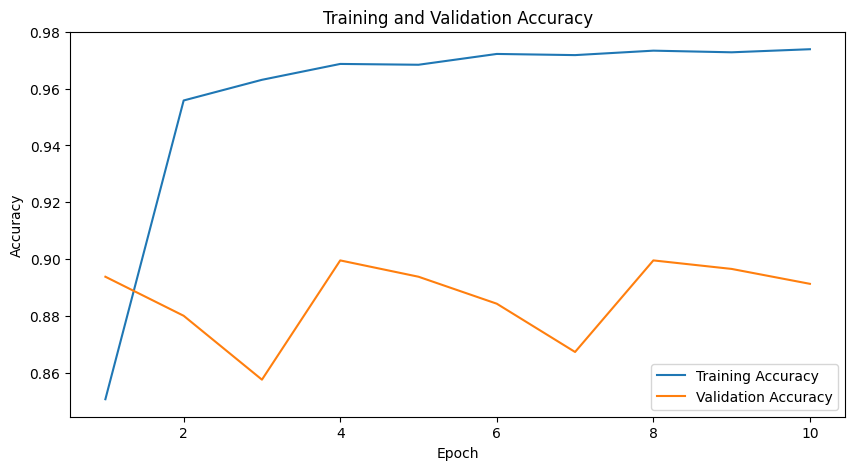

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


#10. Make New Predictions

In [24]:
# Make predictions on new data (Example: a list of review texts)

new_reviews = [

    "The app is very helpful for tracking my health.",

    "I had a bad experience, it kept crashing.",

    "Great app, I would definitely recommend it to others!"

]



# Tokenize the new reviews

new_encodings = tokenizer(new_reviews, truncation=True, padding=True, max_length=128, return_tensors='pt')



# Move the tensors to the appropriate device

new_encodings = {key: val.to(device) for key, val in new_encodings.items()}



# Perform the prediction

model.eval()

with torch.no_grad():

    outputs = model(**new_encodings)

    predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()



# Print the predictions (0 = Negative, 1 = Neutral, 2 = Positive)

for review, pred in zip(new_reviews, predictions):

    sentiment = ['Negative', 'Neutral', 'Positive'][pred]

    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")


Review: The app is very helpful for tracking my health.
Predicted Sentiment: Positive

Review: I had a bad experience, it kept crashing.
Predicted Sentiment: Negative

Review: Great app, I would definitely recommend it to others!
Predicted Sentiment: Positive



#11. SHAP for Model Explanation

In [31]:
# import shap

# # Define a wrapper function for SHAP
# def predict(inputs):
#     """
#     Custom function to make predictions using the model.
#     SHAP expects the output to be a NumPy array, so we convert it here.
#     """
#     # Ensure inputs are reshaped correctly for the tokenizer
#     inputs = np.array(inputs)  # Ensure it's a NumPy array
#     if inputs.ndim == 1:       # Handle 1-dimensional inputs
#         inputs = inputs.reshape(1, -1)

#     # Convert inputs to PyTorch tensors
#     input_ids = torch.tensor(inputs, dtype=torch.long)
#     attention_mask = torch.ones_like(input_ids)  # Assume all tokens are attended

#     # Perform inference with the model
#     with torch.no_grad():
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
#     # Extract logits and convert them to NumPy arrays
#     logits = outputs.logits.detach().cpu().numpy()
#     return logits


# # Create a SHAP explainer
# explainer = shap.Explainer(predict, masker=tokenizer)

# # Prepare the input for SHAP
# sample_review = val_texts[0]  # Change this to the desired text
# sample_encoding = tokenizer(
#     sample_review,
#     truncation=True,
#     padding=True,
#     max_length=128,
#     return_tensors='pt'
# )

# # Convert to the format SHAP expects
# shap_values = explainer({
#     'input_ids': sample_encoding['input_ids'],
#     'attention_mask': sample_encoding['attention_mask']
# })

# # Visualize the SHAP values
# shap.initjs()
# shap.summary_plot(shap_values, sample_encoding['input_ids'])


In [32]:
import shap
import torch
import numpy as np

# Define a wrapper function for SHAP
def predict(inputs):
    """
    Custom function to make predictions using the model.
    SHAP expects the output to be a NumPy array, so we convert it here.
    """
    # Convert inputs to NumPy arrays if they are tensors
    inputs = {key: val.numpy() if isinstance(val, torch.Tensor) else val for key, val in inputs.items()}

    # Convert inputs to PyTorch tensors
    input_ids = torch.tensor(inputs['input_ids'], dtype=torch.long)
    attention_mask = torch.tensor(inputs['attention_mask'], dtype=torch.long)

    # Perform inference with the model
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Extract logits and convert them to NumPy arrays
    logits = outputs.logits.detach().cpu().numpy()
    return logits

# Create a SHAP explainer
explainer = shap.Explainer(predict, masker=tokenizer)

# Prepare the input for SHAP
sample_review = val_texts[0]  # Change this to the desired text
sample_encoding = tokenizer(
    sample_review,
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors='pt'
)

# Convert to the format SHAP expects
shap_values = explainer({
    'input_ids': sample_encoding['input_ids'],
    'attention_mask': sample_encoding['attention_mask']
})

# Visualize the SHAP values
shap.initjs()
shap.summary_plot(shap_values, sample_encoding['input_ids'])


AttributeError: 'numpy.ndarray' object has no attribute 'items'

#12. LIME for Model Explanation

In [ ]:
import lime

from lime.lime_text import LimeTextExplainer



# Initialize a LIME text explainer

explainer = LimeTextExplainer(class_names=['Negative', 'Neutral', 'Positive'])



# Define a function for predicting class probabilities using the BERT model

def predict_proba(texts):

    encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')

    with torch.no_grad():

        logits = model(**encodings).logits

        probs = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()

    return probs



# Choose a sample review from the validation set

sample_review = val_texts[0]



# Explain the prediction for the sample review using LIME

lime_explanation = explainer.explain_instance(sample_review, predict_proba, num_features=10)



# Visualize the LIME explanation

lime_explanation.show_in_notebook(text=True)
